In [37]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import coo_matrix, eye
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error

from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, Birch, DBSCAN
from itertools import chain


ratings = pd.read_csv("data/ml-latest-small/ratings.csv", sep=",", header=0, engine='python')
movies = pd.read_csv("data/ml-latest-small/movies.csv", sep=",", header=0, engine='python')

# Getting all the available movie genres
genres = set(chain(*[x.split("|") for x in movies["genres"]]))
genres.remove("(no genres listed)")

# "genres vector"
for v in genres:
    movies[v] = movies['genres'].str.contains(v)

# movies mean raiting
movies = movies.merge(ratings.groupby('movieId')['rating'].agg([pd.np.mean]), how='left', on='movieId')

genres

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


{'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [38]:
ratings.head(),None, movies.head()

(   userId  movieId  rating  timestamp
 0       1        1     4.0  964982703
 1       1        3     4.0  964981247
 2       1        6     4.0  964982224
 3       1       47     5.0  964983815
 4       1       50     5.0  964982931,
 None,
    movieId                               title  \
 0        1                    Toy Story (1995)   
 1        2                      Jumanji (1995)   
 2        3             Grumpier Old Men (1995)   
 3        4            Waiting to Exhale (1995)   
 4        5  Father of the Bride Part II (1995)   
 
                                         genres  Thriller  Film-Noir  Sci-Fi  \
 0  Adventure|Animation|Children|Comedy|Fantasy     False      False   False   
 1                   Adventure|Children|Fantasy     False      False   False   
 2                               Comedy|Romance     False      False   False   
 3                         Comedy|Drama|Romance     False      False   False   
 4                                       Comedy   

# Macierz użyteczności

Ocena filmu przez użytkownika

In [39]:
utility_matrix = coo_matrix((ratings['rating'], (ratings['userId'], ratings['movieId']))).asfptype()
utility_matrix.toarray(), utility_matrix.toarray().shape

(array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 4. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        ...,
        [0. , 2.5, 2. , ..., 0. , 0. , 0. ],
        [0. , 3. , 0. , ..., 0. , 0. , 0. ],
        [0. , 5. , 0. , ..., 0. , 0. , 0. ]]), (611, 193610))

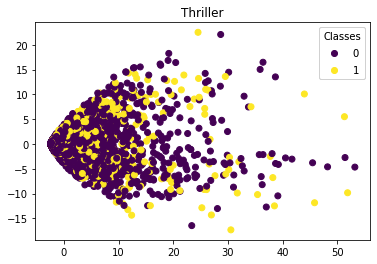

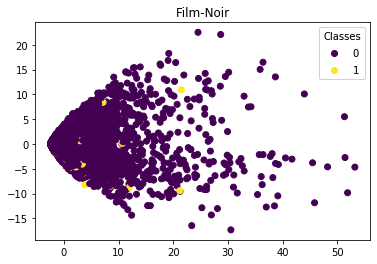

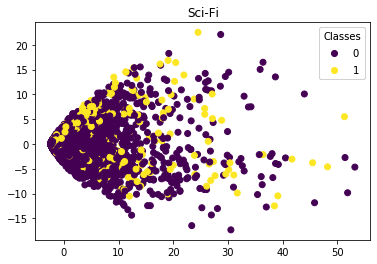

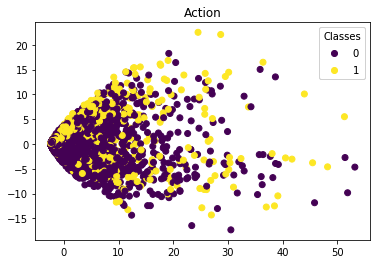

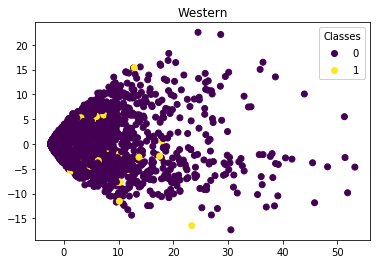

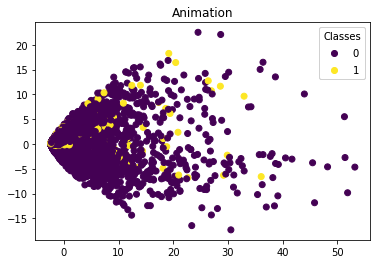

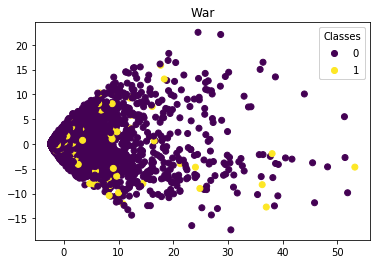

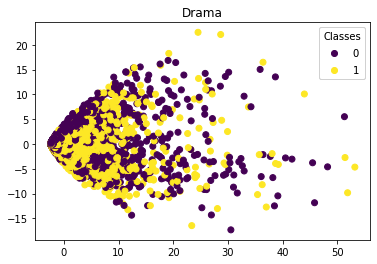

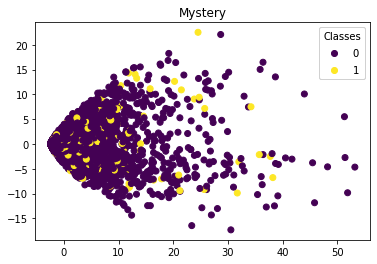

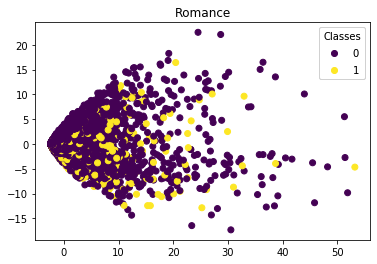

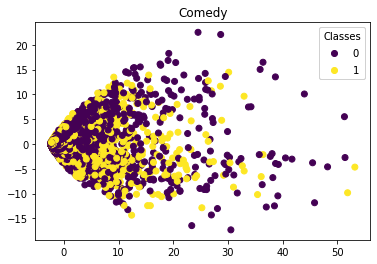

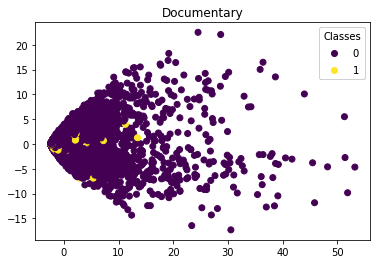

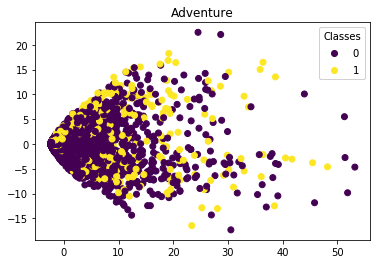

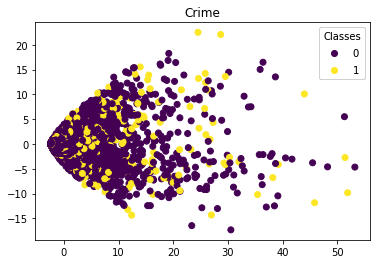

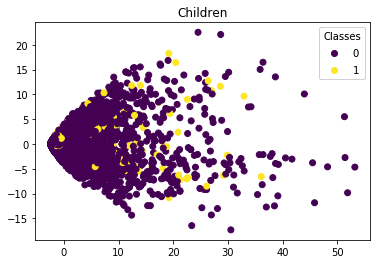

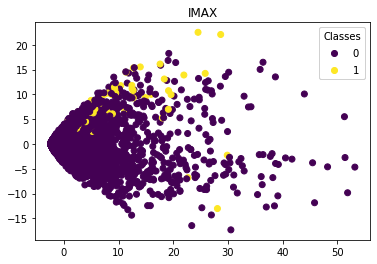

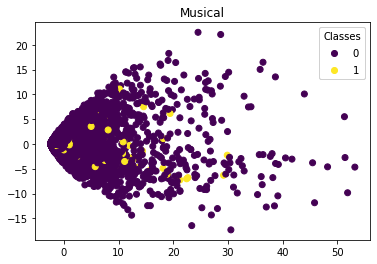

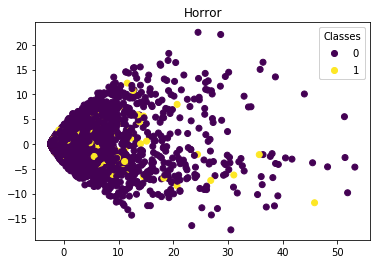

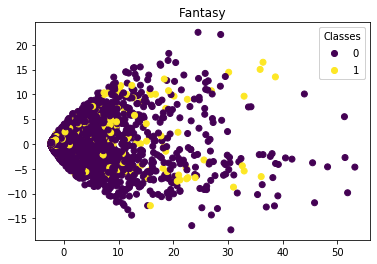

In [72]:
pca_model = PCA(n_components=2)
pca = pca_model.fit_transform(utility_matrix.toarray()[:, movies["movieId"]].T)
for g in genres:
    fig, ax = plt.subplots()
    plt.title(g)
    scatter = ax.scatter(pca[:, 0], pca[:, 1], c = movies[g])
    legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
    ax.add_artist(legend1)
    plt.show()

In [53]:
movies

,movieId,title,genres,Thriller,Film-Noir,Sci-Fi,Action,Western,Animation,War,...,Romance,Comedy,Documentary,Adventure,Crime,Children,IMAX,Musical,Horror,Fantasy
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,False,False,False,False,False,True,False,...,False,True,False,True,False,True,False,False,False,True
1,2,Jumanji (1995),Adventure|Children|Fantasy,False,False,False,False,False,False,False,...,False,False,False,True,False,True,False,False,False,True
2,3,Grumpier Old Men (1995),Comedy|Romance,False,False,False,False,False,False,False,...,True,True,False,False,False,False,False,False,False,False
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,False,False,False,False,False,False,False,...,True,True,False,False,False,False,False,False,False,False
4,5,Father of the Bride Part II (1995),Comedy,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
5,6,Heat (1995),Action|Crime|Thriller,True,False,False,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False
6,7,Sabrina (1995),Comedy|Romance,False,False,False,False,False,False,False,...,True,True,False,False,False,False,False,False,False,False
7,8,Tom and Huck (1995),Adventure|Children,False,False,False,False,False,False,False,...,False,False,False,True,False,True,False,False,False,False
8,9,Sudden Death (1995),Action,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,10,GoldenEye (1995),Action|Adventure|Thriller,True,False,False,True,False,False,False,...,False,False,False,True,False,False,False,False,False,False
